In [1]:
import ROOT as r
r.gROOT.ProcessLine(".L mylib.cc")

Welcome to JupyROOT 6.26/04


0

In [2]:
# start with a model, generate data according to this pdf, then fit

xmin=5
xmax=500
nsamples=3000
model=r.TF1("model","[0]+[1]*log(x)+[2]*log(x)*log(x)",xmin,xmax)
nPars=model.GetNpar()
model.SetNpx(200)
model.SetParameter(0,10)
model.SetParameter(1,5)
model.SetParameter(2,.5)

#generate pseudo data to study
data=r.TH1F("data","data;x;y",40,xmin,xmax);
data.Sumw2()
data.FillRandom("model",nsamples)
xfmin=data.GetBinCenter(1)
xfmax=data.GetBinCenter(data.GetNbinsX())
model.SetRange(xfmin,xfmax)    # fix the model's range from 1st to last bin center for drawing
data.Fit(model,"R","",xfmin,xfmax)
data.Draw()

from array import array
pars=array('d', [0]*nPars)
model.GetParameters(pars)

 FCN=21.3844 FROM MIGRAD    STATUS=CONVERGED      66 CALLS          67 TOTAL
                     EDM=1.29457e-14    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   0.0 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.61398e+01   2.37447e+01  -5.78335e-01   6.25699e-10
   2  p1           6.99078e+00   1.08362e+01   2.68441e-01  -1.69202e-08
   3  p2           7.56271e-01   1.19048e+00  -2.93077e-02   2.50317e-08


Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


In [3]:
# Get the Covariance matrix
fitter = r.TVirtualFitter.GetFitter();  # interface to the extract fitter info
#  assert (nPars == fitter->GetNumberFreeParameters());
COV = r.TMatrixD( nPars, nPars, fitter.GetCovarianceMatrix() )
up=r.TH1F(data);  up.SetLineColor(r.kBlue);  up.SetLineWidth(2)
dn=r.TH1F(data);  dn.SetLineColor(r.kBlue);  dn.SetLineWidth(2)

#calculate error bands using covariance matrix
for ib in range(1,data.GetNbinsX()+1):  
    x=data.GetBinCenter(ib)
    sigma=r.GetCovError(model,x,pars,COV)
    up.SetBinContent(ib,model(x)+sigma)  # multipy sigma by 2.0 to get 2 sigma, etc
    dn.SetBinContent(ib,model(x)-sigma)

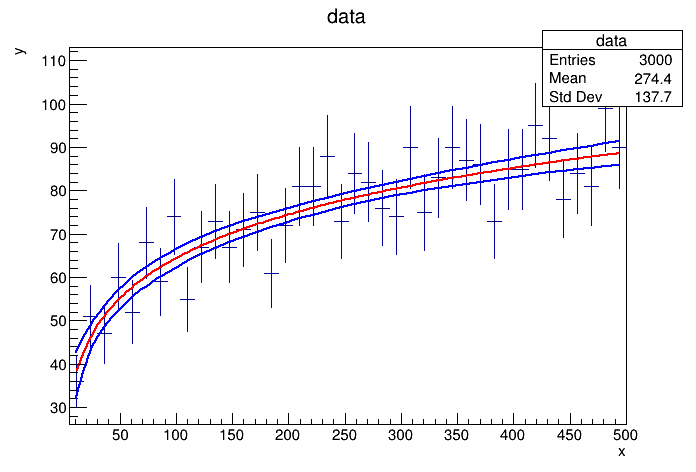

In [4]:
c1=r.TCanvas();
data.Draw()
up.Draw("same,hist,c")
dn.Draw("same,hist,c")
c1.Draw()

Diagonalize covariance matrix

In [5]:
print("Covariance matrix:")
COV.Print()

Covariance matrix:

3x3 matrix is as follows

     |      0    |      1    |      2    |
--------------------------------------------
   0 |      563.8      -253.4       27.05 
   1 |     -253.4       117.4       -12.8 
   2 |      27.05       -12.8       1.417 



In [6]:
print("Eigenvalues/Eigenvectors(columnwise):")
eVals=r.TVectorD(nPars)
eVecs=COV.EigenVectors(eVals)
eVals.Print()
eVecs.Print()

Eigenvalues/Eigenvectors(columnwise):

Vector (3)  is as follows

     |        1  |
------------------
   0 |679.589 
   1 |3.05823 
   2 |0.00217829 


3x3 matrix is as follows

     |      0    |      1    |      2    |
--------------------------------------------
   0 |    -0.9104      0.4124     0.03302 
   1 |     0.4113      0.8938      0.1785 
   2 |   -0.04408     -0.1761      0.9834 



In [7]:
print("eigenvecs (inverse)")
eVecsI=r.TMatrixD(eVecs)
eVecsI.Transpose(eVecsI)  # inverse of eigenvector matrix
eVecsI.Print()

eigenvecs (inverse)

3x3 matrix is as follows

     |      0    |      1    |      2    |
--------------------------------------------
   0 |    -0.9104      0.4113    -0.04408 
   1 |     0.4124      0.8938     -0.1761 
   2 |    0.03302      0.1785      0.9834 



Correlation matrix

In [8]:
from math import sqrt
COR = r.TMatrixD( nPars, nPars, fitter.GetCovarianceMatrix() )
var = r.TMatrixDDiag(COV)
for i in range(nPars):
    for j in range(nPars):
        COR[i][j] = COR[i][j]/sqrt(var[i]*var[j])
print("correlation matrix")
COR.Print()

correlation matrix

3x3 matrix is as follows

     |      0    |      1    |      2    |
--------------------------------------------
   0 |          1     -0.9847      0.9569 
   1 |    -0.9847           1     -0.9924 
   2 |     0.9569     -0.9924           1 



Get eigenvectors into 3x1 TMatrixD objects

In [9]:
eV=[0]*nPars
for i in range(nPars):
    eV[i]=eVecs.GetSub(0,2,i,i)
eV[0].Print()


3x1 matrix is as follows

     |      0    |
------------------
   0 |    -0.9104 
   1 |     0.4113 
   2 |   -0.04408 



Check the math of eigenvector matrix: $MM^T=I$

In [10]:
#eVecs.Print()
#eVecsI.Print()
r.MtimesM(eVecs,eVecsI).Print()


3x3 matrix is as follows

     |      0    |      1    |      2    |
--------------------------------------------
   0 |          1  -1.544e-16   -1.18e-16 
   1 | -1.544e-16           1  -2.776e-16 
   2 |  -1.18e-16  -2.776e-16           1 



Looks good, now let's try an error propogation: <br>
eVecI * p -> p' <br>
take p'[0] and add sqrt(eVal[0]) <br>
get new parameters p_up = p' * eVecI <br>
use this p_up vector to calculate a new error band

In [11]:
# rotate parameter vectors into orthogonal space
parv=r.TMatrixD(nPars,1,pars)
#parv.Print()
print("rotated parameter vector")
par_primed=r.MtimesM(eVecsI,parv)
par_primed.Print()

rotated parameter vector

3x1 matrix is as follows

     |      0    |
------------------
   0 |     -11.85 
   1 |      12.77 
   2 |      2.524 



In [12]:
# Function to propogate errors from eigenvalues into original parameter basis
# Parameter variations based on principal components
# par_primed: TMatrixD[npar][1]
# eVecs: TMatrixD[npar][npar]
# eVals: TMatrixD[npar][1]
# ipar: diagonalized parameter to vary 0(npar-1) corresponds to largest(smallest) eigenvalue
# sign: 1/-1 for up/down
# return: parameter array in original basis with requested variation
def GetPCvar(par_primed, eVecs, eVals, ipar=0, sign=1):
    if ipar>=eVecs.GetNrows():
        print("Error in parameter number")
        return None
    par = r.TMatrixD(par_primed)
    par[ipar][0]=par[ipar][0]+sqrt(eVals[ipar])*sign  # orthogonal parameter vector (fluctuated)
    par=r.MtimesM(eVecs,par)                          # back to original basis
    fluct=array('d', [0]*eVecs.GetNrows())
    for i in range(eVecs.GetNrows()): fluct[i]=par[i][0]
    return fluct

In [13]:
# set all 1 sigma PCA variations for this fit
parv_up=[0]*nPars
parv_dn=[0]*nPars
for i in range(nPars):
    parv_up[i]=GetPCvar(par_primed, eVecs, eVals, ipar=i, sign=1)
    parv_dn[i]=GetPCvar(par_primed, eVecs, eVals, ipar=i, sign=-1)

In [14]:
# return variation of our fit/model using a set of fluctuated parameters
def GetPCvarFcn(model, parv):
    modelv=r.TF1(model)
    modelv.SetLineColor(r.kBlack);  modelv.SetLineWidth(2); modelv.SetLineStyle(2)
    for i in range(model.GetNpar()): modelv.SetParameter(i,parv[i])
    return modelv

Taking the fluctuation wrt the largest eigenvalue, show upper and lower variations

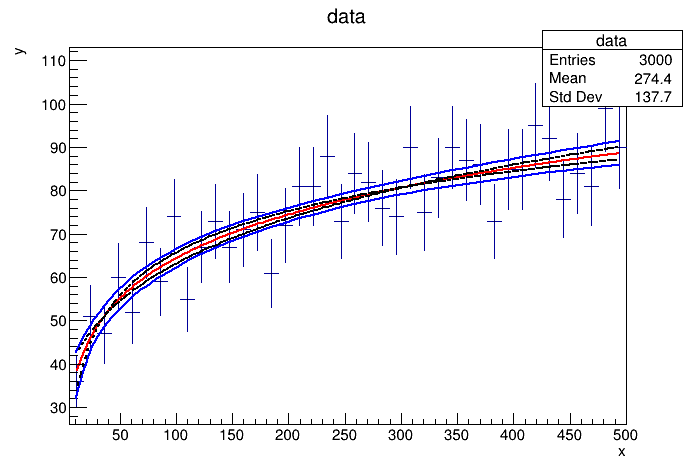

In [15]:
modelv0u=GetPCvarFcn(model,parv_up[0])
modelv0d=GetPCvarFcn(model,parv_dn[0])

data.Draw()
up.Draw("same,hist,c")
dn.Draw("same,hist,c")
modelv0u.Draw("same")
modelv0d.Draw("same")
c1.Draw()